In [11]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import plumed

torch.manual_seed(42)
import nglview as ng
import MDAnalysis as mda

from scipy.interpolate import griddata

%matplotlib inline

In [12]:
#FES for navigation is generated in Trialanine_FES.ipynb

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


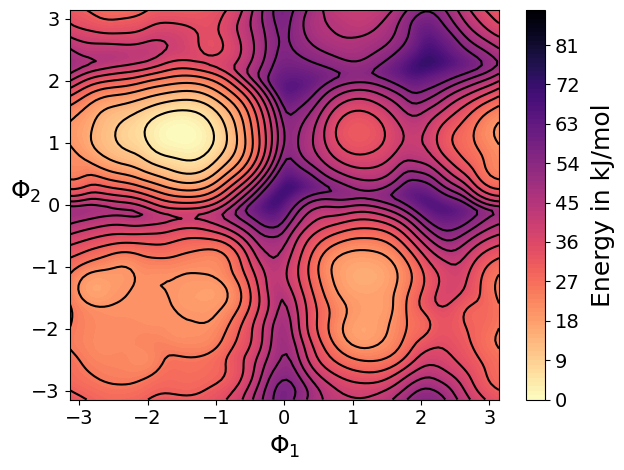

<Figure size 640x480 with 0 Axes>

In [13]:
data=plumed.read_as_pandas("fes-rew_phi1phi2.dat" )

phi_values = data['phi1']
psi_values = data['phi2']
file_free_values = data['file.free']

phi_grid, psi_grid = np.meshgrid(np.linspace(phi_values.min(), phi_values.max(), 100),
                                 np.linspace(psi_values.min(), psi_values.max(), 100))

file_free_grid = griddata((phi_values, psi_values), file_free_values, (phi_grid, psi_grid), method='cubic')

levels=np.arange(0,90,1)
s = plt.contourf(phi_grid, psi_grid, file_free_grid,levels, cmap='magma_r')

levels=np.arange(0,60,5)
plt.contour(phi_grid, psi_grid,file_free_grid,levels,colors='black')

cbar = plt.colorbar(s, shrink=1)
cbar.set_label(r'Energy in kJ/mol', rotation=90, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0)
#ax.set_aspect('equal')
plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()

In [4]:
#get state A

In [5]:
!mkdir ABMD_2Levels

In [5]:
!scp molinfo_trialanine.pdb ./ABMD_2Levels

In [14]:
%%bash 
cat > Production.mdp << EOF
; RUN PARAMETERS
integrator               = md
dt                       = 0.002
nsteps                   = 500000000               ;number of steps 1000000ps 1ms
nstxout                  = 500000000                     ; high precision every 10ps
nstvout                  =     
nstlog                   = 500000000
nstenergy                = 500000000
nstxtcout                = 1
xtc_grps                 = System     ;group(s) to write to xtc trajectory
energygrps               = System       ;group(s) to write to energy file 
                                                
;NEIGHBORING SEARCHING PARAMETERS
nstlist                  = 10                   ;Frequency to update the neighbor list (and the long-range forces, 
ns_type                  = Grid                 ;Make a grid in the box and only check atoms in neighboring grid cells 
                                                ;when constructing a new neighbor list every nstlist steps                                      
pbc                      = xyz                  ; Periodic boudary conditions in all the directions 
rlist                    = 1.0

;OPTIONS FOR ELECTROSTATICS AND VDW
cutoff-scheme            = Verlet
coulombtype              = PME 
pme_order                = 4                     ;cubic interpolation
fourierspacing           = 0.12 
rcoulomb                 = 1.0
vdw-type                 = Cut-off
rvdw                     = 1.0


;TEMPERATURE COUPLING
tcoupl                   = v-rescale            ;Temperature coupling
tc-grps                  = System
tau_t                    = 0.1
ref_t                    = 300

;DISPERSION CORRECTION
DispCorr                 = EnerPres             ; account for vdw cut-off

;PRESSURE COUPLING
Pcoupl                   = no                   ;NVT simulation

continuation             = yes
gen_vel                  = no                   ;Velocity generation
gen_temp                 = 300
gen_seed                 = -1

;OPTIONS FOR BONDS
lincs_iter               = 1
lincs_order              = 4
constraints              = h-bonds
EOF

In [15]:
%%bash 
gmx_mpi grompp -f Production.mdp -c newbox_Alanine_Tripeptide.gro -p topol.top -n index.ndx -o ./ABMD_2Levels/MD.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f Production.mdp -c newbox_Alanine_Tripeptide.gro -p topol.top -n index.ndx -o ./ABMD_2Levels/MD.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group System is 101.00

NOTE 1 [file Production.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.




Setting the LD random seed to -1679624452

Generated 3485 of the 3486 non-bonded parameter combinations

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...

The largest distance between excluded atoms is 0.384 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.000 nm, buffer size 0.000 nm

Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 28x28x28, spacing 0.110 0.110 0.110

Estimate for the relative computational load of the PME mesh part: 0.95


In [16]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')

lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=1.4,-1.0,-1.1 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=1.4,-1.1,-1.2\n' )
lines.append('   BASIN_UL1=1.5,-0.9,-1.0\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_getA ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_getA1.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [17]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s MD -plumed plumed_getA1.dat -deffnm getA1 -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s MD -plumed plumed_getA1.dat -deffnm getA1 -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up getA1.log to ./#getA1.log.2#
Reading file MD.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps, 1e+05 ps
Changing nstlist f

In [18]:
!gmx_mpi check -f ./ABMD_2Levels/getA1.xtc

             :-) GROMACS - gmx check, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi check -f ./ABMD_2Levels/getA1.xtc

Checking file ./ABMD_2Levels/getA1.xtc
Reading frame       0 time    0.000   
# Atoms  42
Precision 0.001 (nm)
Reading frame    1400 time    2.800   


Item        #frames Timestep (ps)
Step          1434    0.002
Time          1434    0.002
Lambda           0
Coords        1434    0.002
Velocities       0
Forces           0
Box           1434    0.002

GROMACS reminds you: "Unfortunately, "simulation" has become increasingly misused to mean nothing more than "calculation"" (Bill Jorgensen)



In [19]:
print(1434*0.002)

2.868


In [20]:
%%bash

echo 0| gmx_mpi trjconv -f ./ABMD_2Levels/getA1.xtc -s newbox_Alanine_Tripeptide.gro -dump 2.868 -o ./ABMD_2Levels/stateA1.pdb


            :-) GROMACS - gmx trjconv, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi trjconv -f ./ABMD_2Levels/getA1.xtc -s newbox_Alanine_Tripeptide.gro -dump 2.868 -o ./ABMD_2Levels/stateA1.pdb

Will write pdb: Protein data bank file
Group     0 (         System) has    42 elements
Group     1 (        Protein) has    42 elements
Group     2 (      Protein-H) has    20 elements
Group     3 (        C-alpha) has     3 elements
Group     4 (       Backbone) has    11 elements
Group     5 (      MainChain) has    15 elements
Group     6 (   MainChain+Cb) has    18 elements
Group     7 (    MainChain+H) has    19 elements
Group     8 (      SideChain) has    23 elements
Group     9 ( 

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


In [21]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')

lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=1.4,-1.0,1.1 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=1.4,-1.1,1.0\n' )
lines.append('   BASIN_UL1=1.5,-0.9,1.2\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_getA ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_getA2.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [22]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s MD -plumed plumed_getA2.dat -deffnm getA2 -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s MD -plumed plumed_getA2.dat -deffnm getA2 -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up getA2.log to ./#getA2.log.1#
Reading file MD.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps, 1e+05 ps
Changing nstlist f

In [23]:
!gmx_mpi check -f ./ABMD_2Levels/getA2.xtc

             :-) GROMACS - gmx check, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi check -f ./ABMD_2Levels/getA2.xtc

Checking file ./ABMD_2Levels/getA2.xtc
Reading frame       0 time    0.000   
# Atoms  42
Precision 0.001 (nm)
Reading frame    2000 time    4.000   


Item        #frames Timestep (ps)
Step          2420    0.002
Time          2420    0.002
Lambda           0
Coords        2420    0.002
Velocities       0
Forces           0
Box           2420    0.002

GROMACS reminds you: "I've Got Two Turntables and a Microphone" (B. Hansen)



In [24]:
print(2420*0.002)

4.84


In [25]:
%%bash

echo 0| gmx_mpi trjconv -f ./ABMD_2Levels/getA2.xtc -s newbox_Alanine_Tripeptide.gro -dump 4.84 -o ./ABMD_2Levels/stateA2.pdb


            :-) GROMACS - gmx trjconv, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi trjconv -f ./ABMD_2Levels/getA2.xtc -s newbox_Alanine_Tripeptide.gro -dump 4.84 -o ./ABMD_2Levels/stateA2.pdb

Will write pdb: Protein data bank file
Group     0 (         System) has    42 elements
Group     1 (        Protein) has    42 elements
Group     2 (      Protein-H) has    20 elements
Group     3 (        C-alpha) has     3 elements
Group     4 (       Backbone) has    11 elements
Group     5 (      MainChain) has    15 elements
Group     6 (   MainChain+Cb) has    18 elements
Group     7 (    MainChain+H) has    19 elements
Group     8 (      SideChain) has    23 elements
Group     9 (  

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


In [26]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')

lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=1.4,-1.0,0.0 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=1.4,-1.1,-0.2\n' )
lines.append('   BASIN_UL1=1.5,-0.9,0.2\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_getA ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_getA3.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [27]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s MD -plumed plumed_getA3.dat -deffnm getA3 -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s MD -plumed plumed_getA3.dat -deffnm getA3 -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up getA3.log to ./#getA3.log.1#
Reading file MD.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps, 1e+05 ps
Changing nstlist f

In [28]:
!gmx_mpi check -f ./ABMD_2Levels/getA3.xtc

             :-) GROMACS - gmx check, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi check -f ./ABMD_2Levels/getA3.xtc

Checking file ./ABMD_2Levels/getA3.xtc
Reading frame       0 time    0.000   
# Atoms  42
Precision 0.001 (nm)
Reading frame   29000 time   58.000   


Item        #frames Timestep (ps)
Step         29514    0.002
Time         29514    0.002
Lambda           0
Coords       29514    0.002
Velocities       0
Forces           0
Box          29514    0.002

GROMACS reminds you: "Science is not a boy's game, it's not a girl's game. It's everyone's game. It's about where we are and where we're going." (Nichelle Nichols)



In [29]:
print(29514*0.002)

59.028


In [30]:
%%bash

echo 0| gmx_mpi trjconv -f ./ABMD_2Levels/getA3.xtc -s newbox_Alanine_Tripeptide.gro -dump 59.028 -o ./ABMD_2Levels/stateA3.pdb


            :-) GROMACS - gmx trjconv, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi trjconv -f ./ABMD_2Levels/getA3.xtc -s newbox_Alanine_Tripeptide.gro -dump 59.028 -o ./ABMD_2Levels/stateA3.pdb

Will write pdb: Protein data bank file
Group     0 (         System) has    42 elements
Group     1 (        Protein) has    42 elements
Group     2 (      Protein-H) has    20 elements
Group     3 (        C-alpha) has     3 elements
Group     4 (       Backbone) has    11 elements
Group     5 (      MainChain) has    15 elements
Group     6 (   MainChain+Cb) has    18 elements
Group     7 (    MainChain+H) has    19 elements
Group     8 (      SideChain) has    23 elements
Group     9 (

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


In [31]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')

lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=1.4,-1.0,3.0 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=1.4,-1.1,2.9\n' )
lines.append('   BASIN_UL1=1.5,-0.9,3.1\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_getA ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_getA4.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [32]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s MD -plumed plumed_getA4.dat -deffnm getA4 -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s MD -plumed plumed_getA4.dat -deffnm getA4 -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up getA4.log to ./#getA4.log.1#
Reading file MD.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps, 1e+05 ps
Changing nstlist f

In [33]:
!gmx_mpi check -f ./ABMD_2Levels/getA4.xtc

             :-) GROMACS - gmx check, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi check -f ./ABMD_2Levels/getA4.xtc

Checking file ./ABMD_2Levels/getA4.xtc
Reading frame       0 time    0.000   
# Atoms  42
Precision 0.001 (nm)
Reading frame    1300 time    2.600   


Item        #frames Timestep (ps)
Step          1365    0.002
Time          1365    0.002
Lambda           0
Coords        1365    0.002
Velocities       0
Forces           0
Box           1365    0.002

GROMACS reminds you: "As we all know, blinking lights means science." (Joss Whedon)



In [34]:
print(1365*0.002)

2.73


In [35]:
%%bash

echo 0| gmx_mpi trjconv -f ./ABMD_2Levels/getA4.xtc -s newbox_Alanine_Tripeptide.gro -dump 2.73 -o ./ABMD_2Levels/stateA4.pdb


            :-) GROMACS - gmx trjconv, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi trjconv -f ./ABMD_2Levels/getA4.xtc -s newbox_Alanine_Tripeptide.gro -dump 2.73 -o ./ABMD_2Levels/stateA4.pdb

Will write pdb: Protein data bank file
Group     0 (         System) has    42 elements
Group     1 (        Protein) has    42 elements
Group     2 (      Protein-H) has    20 elements
Group     3 (        C-alpha) has     3 elements
Group     4 (       Backbone) has    11 elements
Group     5 (      MainChain) has    15 elements
Group     6 (   MainChain+Cb) has    18 elements
Group     7 (    MainChain+H) has    19 elements
Group     8 (      SideChain) has    23 elements
Group     9 (  

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


In [36]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')

lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=1.4,-1.0,-3.0 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=1.4,-1.1,-3.1\n' )
lines.append('   BASIN_UL1=1.5,-0.9,-2.9\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_getA ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_getA5.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [37]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s MD -plumed plumed_getA5.dat -deffnm getA5 -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s MD -plumed plumed_getA5.dat -deffnm getA5 -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up getA5.log to ./#getA5.log.1#
Reading file MD.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps, 1e+05 ps
Changing nstlist f

In [38]:
!gmx_mpi check -f ./ABMD_2Levels/getA5.xtc

             :-) GROMACS - gmx check, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi check -f ./ABMD_2Levels/getA5.xtc

Checking file ./ABMD_2Levels/getA5.xtc
Reading frame       0 time    0.000   
# Atoms  42
Precision 0.001 (nm)
Reading frame    1800 time    3.600   


Item        #frames Timestep (ps)
Step          1823    0.002
Time          1823    0.002
Lambda           0
Coords        1823    0.002
Velocities       0
Forces           0
Box           1823    0.002

GROMACS reminds you: "Interfacing Space and Beyond..." (P. J. Harvey)



In [39]:
print(1823*0.002)

3.646


In [40]:
%%bash

echo 0| gmx_mpi trjconv -f ./ABMD_2Levels/getA5.xtc -s newbox_Alanine_Tripeptide.gro -dump 3.646 -o ./ABMD_2Levels/stateA5.pdb


            :-) GROMACS - gmx trjconv, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi trjconv -f ./ABMD_2Levels/getA5.xtc -s newbox_Alanine_Tripeptide.gro -dump 3.646 -o ./ABMD_2Levels/stateA5.pdb

Will write pdb: Protein data bank file
Group     0 (         System) has    42 elements
Group     1 (        Protein) has    42 elements
Group     2 (      Protein-H) has    20 elements
Group     3 (        C-alpha) has     3 elements
Group     4 (       Backbone) has    11 elements
Group     5 (      MainChain) has    15 elements
Group     6 (   MainChain+Cb) has    18 elements
Group     7 (    MainChain+H) has    19 elements
Group     8 (      SideChain) has    23 elements
Group     9 ( 

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


In [41]:
!find . -type f -name "#*" -exec rm -rf {} +
!find . -type f -name "bck*" -exec rm -rf {} +

# AB

In [42]:
!gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateA1.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetAB1.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateA1.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetAB1.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Setting the LD random seed to -1394647045

Generated 3485 of the 3486 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...
Number of degrees of freedom in T-Coupling 

In [43]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')


lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=-1.5,-1.1,-1.1 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=-1.6,-2.0,-1.2\n')
lines.append('   BASIN_UL1=-1.0,-1.0,-1.0\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_ratchetAB1 ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_AB1.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [44]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s RatchetAB1 -deffnm RatchetAB1 -plumed plumed_AB1.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s RatchetAB1 -deffnm RatchetAB1 -plumed plumed_AB1.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up RatchetAB1.log to ./#RatchetAB1.log.1#
Reading file RatchetAB1.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps

In [45]:
!gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateA2.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetAB2.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateA2.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetAB2.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Setting the LD random seed to -2249783

Generated 3485 of the 3486 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...
Number of degrees of freedom in T-Coupling gro

In [46]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')


lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=-1.5,-1.1,1.1 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=-1.6,-2.0,1.0\n')
lines.append('   BASIN_UL1=-1.0,-1.0,1.2\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_ratchetAB2 ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_AB2.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [47]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s RatchetAB2 -deffnm RatchetAB2 -plumed plumed_AB2.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s RatchetAB2 -deffnm RatchetAB2 -plumed plumed_AB2.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up RatchetAB2.log to ./#RatchetAB2.log.1#
Reading file RatchetAB2.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps

In [48]:
!gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateA3.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetAB3.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateA3.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetAB3.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Setting the LD random seed to 1554490351

Generated 3485 of the 3486 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...
Number of degrees of freedom in T-Coupling g

In [49]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')


lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=-1.5,-1.1,0.0 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=-1.6,-2.0,-0.2\n')
lines.append('   BASIN_UL1=-1.0,-1.0,0.2\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_ratchetAB3 ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_AB3.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [50]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s RatchetAB3 -deffnm RatchetAB3 -plumed plumed_AB3.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s RatchetAB3 -deffnm RatchetAB3 -plumed plumed_AB3.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up RatchetAB3.log to ./#RatchetAB3.log.1#
Reading file RatchetAB3.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps

In [51]:
!gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateA4.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetAB4.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateA4.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetAB4.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Setting the LD random seed to 2097117647

Generated 3485 of the 3486 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...
Number of degrees of freedom in T-Coupling g

In [52]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')


lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=-1.5,-1.1,3.0 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=-1.6,-2.0,2.9\n')
lines.append('   BASIN_UL1=-1.0,-1.0,3.1\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_ratchetAB4 ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_AB4.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [53]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s RatchetAB4 -deffnm RatchetAB4 -plumed plumed_AB4.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s RatchetAB4 -deffnm RatchetAB4 -plumed plumed_AB4.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up RatchetAB4.log to ./#RatchetAB4.log.1#
Reading file RatchetAB4.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps

In [54]:
!gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateA5.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetAB5.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateA5.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetAB5.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Setting the LD random seed to -306776065

Generated 3485 of the 3486 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...
Number of degrees of freedom in T-Coupling g

In [55]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')


lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=-1.5,-1.1,-3.0 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=-1.6,-2.0,-3.1\n')
lines.append('   BASIN_UL1=-1.0,-1.0,-2.9\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_ratchetAB5 ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_AB5.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [56]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s RatchetAB5 -deffnm RatchetAB5 -plumed plumed_AB5.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s RatchetAB5 -deffnm RatchetAB5 -plumed plumed_AB5.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up RatchetAB5.log to ./#RatchetAB5.log.1#
Reading file RatchetAB5.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps

In [57]:
!find . -type f -name "#*" -exec rm -rf {} +
!find . -type f -name "step*" -exec rm -rf {} +
!find . -type f -name "bck*" -exec rm -rf {} +

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt

435
385
738
623
439


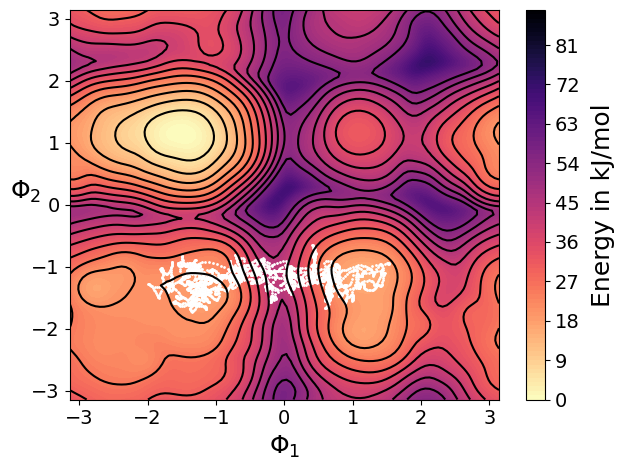

<Figure size 640x480 with 0 Axes>

In [58]:
data=plumed.read_as_pandas("fes-rew_phi1phi2.dat" )

phi_values = data['phi1']
psi_values = data['phi2']
file_free_values = data['file.free']

phi_grid, psi_grid = np.meshgrid(np.linspace(phi_values.min(), phi_values.max(), 100),
                                 np.linspace(psi_values.min(), psi_values.max(), 100))

file_free_grid = griddata((phi_values, psi_values), file_free_values, (phi_grid, psi_grid), method='cubic')

levels=np.arange(0,90,1)
s = plt.contourf(phi_grid, psi_grid, file_free_grid,levels, cmap='magma_r')

levels=np.arange(0,60,5)
plt.contour(phi_grid, psi_grid,file_free_grid,levels,colors='black')


for i in range(1,6):
    colvar_forward=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetAB%s" %i)
    
    print(len(colvar_forward['phi1']))
    phi_forward=colvar_forward['phi1']
    psi_forward=colvar_forward['phi2']
    

    plt.scatter(phi_forward,psi_forward,c='white',s=1)

cbar = plt.colorbar(s, shrink=1)
cbar.set_label(r'Energy in kJ/mol', rotation=90, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0)
#ax.set_aspect('equal')
plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()

# Get structures state B

In [59]:
!gmx_mpi check -f ./ABMD_2Levels/RatchetAB1.xtc

             :-) GROMACS - gmx check, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi check -f ./ABMD_2Levels/RatchetAB1.xtc

Checking file ./ABMD_2Levels/RatchetAB1.xtc
Reading frame       0 time    0.000   
# Atoms  42
Precision 0.001 (nm)
Reading frame     400 time    0.800   


Item        #frames Timestep (ps)
Step           435    0.002
Time           435    0.002
Lambda           0
Coords         435    0.002
Velocities       0
Forces           0
Box            435    0.002

GROMACS reminds you: "Welcome to the Power Age" (2 Unlimited)



In [64]:
print(435*0.002)

0.87


In [65]:
%%bash

echo 0| gmx_mpi trjconv -f ./ABMD_2Levels/RatchetAB1.xtc -s newbox_Alanine_Tripeptide.gro -dump 0.87 -o ./ABMD_2Levels/stateB1.pdb


            :-) GROMACS - gmx trjconv, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi trjconv -f ./ABMD_2Levels/RatchetAB1.xtc -s newbox_Alanine_Tripeptide.gro -dump 0.87 -o ./ABMD_2Levels/stateB1.pdb

Will write pdb: Protein data bank file
Group     0 (         System) has    42 elements
Group     1 (        Protein) has    42 elements
Group     2 (      Protein-H) has    20 elements
Group     3 (        C-alpha) has     3 elements
Group     4 (       Backbone) has    11 elements
Group     5 (      MainChain) has    15 elements
Group     6 (   MainChain+Cb) has    18 elements
Group     7 (    MainChain+H) has    19 elements
Group     8 (      SideChain) has    23 elements
Group     

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


In [66]:
!gmx_mpi check -f ./ABMD_2Levels/RatchetAB2.xtc

             :-) GROMACS - gmx check, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi check -f ./ABMD_2Levels/RatchetAB2.xtc

Checking file ./ABMD_2Levels/RatchetAB2.xtc
Reading frame       0 time    0.000   
# Atoms  42
Precision 0.001 (nm)
Reading frame     300 time    0.600   


Item        #frames Timestep (ps)
Step           385    0.002
Time           385    0.002
Lambda           0
Coords         385    0.002
Velocities       0
Forces           0
Box            385    0.002

GROMACS reminds you: "Science adjusts its views based on what's observed. Faith is the denial of observation so that belief can be preserved." (Tim Minchin)



In [67]:
print(385*0.002)

0.77


In [68]:
%%bash

echo 0| gmx_mpi trjconv -f ./ABMD_2Levels/RatchetAB2.xtc -s newbox_Alanine_Tripeptide.gro -dump 0.77 -o ./ABMD_2Levels/stateB2.pdb


            :-) GROMACS - gmx trjconv, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi trjconv -f ./ABMD_2Levels/RatchetAB2.xtc -s newbox_Alanine_Tripeptide.gro -dump 0.77 -o ./ABMD_2Levels/stateB2.pdb

Will write pdb: Protein data bank file
Group     0 (         System) has    42 elements
Group     1 (        Protein) has    42 elements
Group     2 (      Protein-H) has    20 elements
Group     3 (        C-alpha) has     3 elements
Group     4 (       Backbone) has    11 elements
Group     5 (      MainChain) has    15 elements
Group     6 (   MainChain+Cb) has    18 elements
Group     7 (    MainChain+H) has    19 elements
Group     8 (      SideChain) has    23 elements
Group     

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


In [78]:
!gmx_mpi check -f ./ABMD_2Levels/RatchetAB3.xtc

             :-) GROMACS - gmx check, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi check -f ./ABMD_2Levels/RatchetAB3.xtc

Checking file ./ABMD_2Levels/RatchetAB3.xtc
Reading frame       0 time    0.000   
# Atoms  42
Precision 0.001 (nm)
Reading frame     700 time    1.400   


Item        #frames Timestep (ps)
Step           738    0.002
Time           738    0.002
Lambda           0
Coords         738    0.002
Velocities       0
Forces           0
Box            738    0.002

GROMACS reminds you: "Don't waste pure thoughts on dirty enzymes." (Efraim Racker)



In [79]:
print(738*0.002)

1.476


In [80]:
%%bash

echo 0| gmx_mpi trjconv -f ./ABMD_2Levels/RatchetAB3.xtc -s newbox_Alanine_Tripeptide.gro -dump 1.476 -o ./ABMD_2Levels/stateB3.pdb


            :-) GROMACS - gmx trjconv, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi trjconv -f ./ABMD_2Levels/RatchetAB3.xtc -s newbox_Alanine_Tripeptide.gro -dump 1.476 -o ./ABMD_2Levels/stateB3.pdb

Will write pdb: Protein data bank file
Group     0 (         System) has    42 elements
Group     1 (        Protein) has    42 elements
Group     2 (      Protein-H) has    20 elements
Group     3 (        C-alpha) has     3 elements
Group     4 (       Backbone) has    11 elements
Group     5 (      MainChain) has    15 elements
Group     6 (   MainChain+Cb) has    18 elements
Group     7 (    MainChain+H) has    19 elements
Group     8 (      SideChain) has    23 elements
Group    

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


In [81]:
!gmx_mpi check -f ./ABMD_2Levels/RatchetAB4.xtc

             :-) GROMACS - gmx check, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi check -f ./ABMD_2Levels/RatchetAB4.xtc

Checking file ./ABMD_2Levels/RatchetAB4.xtc
Reading frame       0 time    0.000   
# Atoms  42
Precision 0.001 (nm)
Reading frame     600 time    1.200   


Item        #frames Timestep (ps)
Step           623    0.002
Time           623    0.002
Lambda           0
Coords         623    0.002
Velocities       0
Forces           0
Box            623    0.002

GROMACS reminds you: "Problems worthy of attack prove their worth by hitting back." (Piet Hein)



In [82]:
print(623*0.002)

1.246


In [83]:
%%bash

echo 0| gmx_mpi trjconv -f ./ABMD_2Levels/RatchetAB4.xtc -s newbox_Alanine_Tripeptide.gro -dump 1.246 -o ./ABMD_2Levels/stateB4.pdb


            :-) GROMACS - gmx trjconv, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi trjconv -f ./ABMD_2Levels/RatchetAB4.xtc -s newbox_Alanine_Tripeptide.gro -dump 1.246 -o ./ABMD_2Levels/stateB4.pdb

Will write pdb: Protein data bank file
Group     0 (         System) has    42 elements
Group     1 (        Protein) has    42 elements
Group     2 (      Protein-H) has    20 elements
Group     3 (        C-alpha) has     3 elements
Group     4 (       Backbone) has    11 elements
Group     5 (      MainChain) has    15 elements
Group     6 (   MainChain+Cb) has    18 elements
Group     7 (    MainChain+H) has    19 elements
Group     8 (      SideChain) has    23 elements
Group    

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


In [84]:
!gmx_mpi check -f ./ABMD_2Levels/RatchetAB5.xtc

             :-) GROMACS - gmx check, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi check -f ./ABMD_2Levels/RatchetAB5.xtc

Checking file ./ABMD_2Levels/RatchetAB5.xtc
Reading frame       0 time    0.000   
# Atoms  42
Precision 0.001 (nm)
Reading frame     400 time    0.800   


Item        #frames Timestep (ps)
Step           439    0.002
Time           439    0.002
Lambda           0
Coords         439    0.002
Velocities       0
Forces           0
Box            439    0.002

GROMACS reminds you: "Either you will be dashed to atoms on crag points, or lifted up and borne by some master-wave into a calmer current" (Charlotte Bronte)



In [85]:
print(439*0.002)

0.878


In [86]:
%%bash

echo 0| gmx_mpi trjconv -f ./ABMD_2Levels/RatchetAB5.xtc -s newbox_Alanine_Tripeptide.gro -dump 0.878 -o ./ABMD_2Levels/stateB5.pdb


            :-) GROMACS - gmx trjconv, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi trjconv -f ./ABMD_2Levels/RatchetAB5.xtc -s newbox_Alanine_Tripeptide.gro -dump 0.878 -o ./ABMD_2Levels/stateB5.pdb

Will write pdb: Protein data bank file
Group     0 (         System) has    42 elements
Group     1 (        Protein) has    42 elements
Group     2 (      Protein-H) has    20 elements
Group     3 (        C-alpha) has     3 elements
Group     4 (       Backbone) has    11 elements
Group     5 (      MainChain) has    15 elements
Group     6 (   MainChain+Cb) has    18 elements
Group     7 (    MainChain+H) has    19 elements
Group     8 (      SideChain) has    23 elements
Group    

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


In [87]:
!find . -type f -name "#*" -exec rm -rf {} +
!find . -type f -name "step*" -exec rm -rf {} +
!find . -type f -name "bck*" -exec rm -rf {} +

# BC

In [88]:
!gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB1.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBC1.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB1.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBC1.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Setting the LD random seed to -134480638

Generated 3485 of the 3486 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...
Number of degrees of freedom in T-Coupling g

In [89]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')


lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=-1.6,1.1,-1.1 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=-1.7,1.1,-1.2\n')
lines.append('   BASIN_UL1=-1.3,2,-1.0\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_ratchetBC1 ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_BC1.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [90]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s RatchetBC1 -deffnm RatchetBC1 -plumed plumed_BC1.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s RatchetBC1 -deffnm RatchetBC1 -plumed plumed_BC1.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up RatchetBC1.log to ./#RatchetBC1.log.1#
Reading file RatchetBC1.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps

In [91]:
!gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB2.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBC2.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB2.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBC2.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Setting the LD random seed to 1979407815

Generated 3485 of the 3486 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...
Number of degrees of freedom in T-Coupling g

In [92]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')


lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=-1.6,1.1,1.1 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=-1.7,1.1,1.0\n')
lines.append('   BASIN_UL1=-1.3,2,1.2\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_ratchetBC2 ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_BC2.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [93]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s RatchetBC2 -deffnm RatchetBC2 -plumed plumed_BC2.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s RatchetBC2 -deffnm RatchetBC2 -plumed plumed_BC2.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up RatchetBC2.log to ./#RatchetBC2.log.1#
Reading file RatchetBC2.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps

In [94]:
!gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB3.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBC3.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB3.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBC3.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Setting the LD random seed to -152870978

Generated 3485 of the 3486 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...
Number of degrees of freedom in T-Coupling g

In [95]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')


lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=-1.6,1.1,0.0 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=-1.7,1.1,-0.2\n')
lines.append('   BASIN_UL1=-1.3,2,0.2\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_ratchetBC3 ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_BC3.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [96]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s RatchetBC3 -deffnm RatchetBC3 -plumed plumed_BC3.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s RatchetBC3 -deffnm RatchetBC3 -plumed plumed_BC3.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up RatchetBC3.log to ./#RatchetBC3.log.1#
Reading file RatchetBC3.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps

In [97]:
!gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB4.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBC4.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB4.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBC4.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Setting the LD random seed to 2145343467

Generated 3485 of the 3486 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...
Number of degrees of freedom in T-Coupling g

In [98]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')


lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=-1.6,1.1,3.0 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=-1.7,1.1,2.9\n')
lines.append('   BASIN_UL1=-1.3,2,3.1\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_ratchetBC4 ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_BC4.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [99]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s RatchetBC4 -deffnm RatchetBC4 -plumed plumed_BC4.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s RatchetBC4 -deffnm RatchetBC4 -plumed plumed_BC4.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up RatchetBC4.log to ./#RatchetBC4.log.1#
Reading file RatchetBC4.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps

In [100]:
!gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB5.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBC5.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB5.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBC5.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Setting the LD random seed to -202326299

Generated 3485 of the 3486 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...
Number of degrees of freedom in T-Coupling g

In [101]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')


lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=-1.6,1.1,-3.0 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=-1.7,1.1,-3.1\n')
lines.append('   BASIN_UL1=-1.3,2,-2.9\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_ratchetBC5 ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_BC5.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [102]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s RatchetBC5 -deffnm RatchetBC5 -plumed plumed_BC5.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s RatchetBC5 -deffnm RatchetBC5 -plumed plumed_BC5.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up RatchetBC5.log to ./#RatchetBC5.log.1#
Reading file RatchetBC5.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps

In [103]:
!find . -type f -name "#*" -exec rm -rf {} +
!find . -type f -name "step*" -exec rm -rf {} +
!find . -type f -name "bck*" -exec rm -rf {} +

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt

722
622
675
1302
686


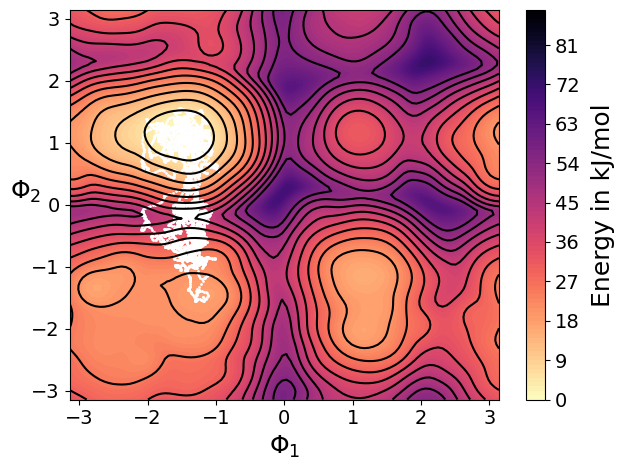

<Figure size 640x480 with 0 Axes>

In [105]:
data=plumed.read_as_pandas("fes-rew_phi1phi2.dat" )


phi_values = data['phi1']
psi_values = data['phi2']
file_free_values = data['file.free']

phi_grid, psi_grid = np.meshgrid(np.linspace(phi_values.min(), phi_values.max(), 100),
                                 np.linspace(psi_values.min(), psi_values.max(), 100))

file_free_grid = griddata((phi_values, psi_values), file_free_values, (phi_grid, psi_grid), method='cubic')

levels=np.arange(0,90,1)
s = plt.contourf(phi_grid, psi_grid, file_free_grid,levels, cmap='magma_r')

levels=np.arange(0,60,5)
plt.contour(phi_grid, psi_grid,file_free_grid,levels,colors='black')

for i in range(1,6):
    colvar_forward=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetBC%s" %i)
    
    print(len(colvar_forward['phi1']))
    phi_forward=colvar_forward['phi1']
    psi_forward=colvar_forward['phi2']
    plt.scatter(phi_forward,psi_forward,c='white',s=1)

cbar = plt.colorbar(s, shrink=1)
cbar.set_label(r'Energy in kJ/mol', rotation=90, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0)
#ax.set_aspect('equal')
plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()

# Get structures state C

In [152]:
!gmx_mpi check -f ./ABMD_2Levels/RatchetBC1.xtc

             :-) GROMACS - gmx check, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi check -f ./ABMD_2Levels/RatchetBC1.xtc

Checking file ./ABMD_2Levels/RatchetBC1.xtc
Reading frame       0 time    0.000   
# Atoms  42
Precision 0.001 (nm)
Reading frame    1000 time    2.000   


Item        #frames Timestep (ps)
Step          1067    0.002
Time          1067    0.002
Lambda           0
Coords        1067    0.002
Velocities       0
Forces           0
Box           1067    0.002

GROMACS reminds you: "They Were So Quiet About It" (Pixies)



In [153]:
print(1067*0.002)

2.134


In [154]:
%%bash

echo 0| gmx_mpi trjconv -f ./ABMD_2Levels/RatchetBC1.xtc -s newbox_Alanine_Tripeptide.gro -dump 2.134 -o ./ABMD_2Levels/stateC1.pdb


            :-) GROMACS - gmx trjconv, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi trjconv -f ./ABMD_2Levels/RatchetBC1.xtc -s newbox_Alanine_Tripeptide.gro -dump 2.134 -o ./ABMD_2Levels/stateC1.pdb

Will write pdb: Protein data bank file
Group     0 (         System) has    42 elements
Group     1 (        Protein) has    42 elements
Group     2 (      Protein-H) has    20 elements
Group     3 (        C-alpha) has     3 elements
Group     4 (       Backbone) has    11 elements
Group     5 (      MainChain) has    15 elements
Group     6 (   MainChain+Cb) has    18 elements
Group     7 (    MainChain+H) has    19 elements
Group     8 (      SideChain) has    23 elements
Group    

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


In [155]:
!gmx_mpi check -f ./ABMD_2Levels/RatchetBC2.xtc

             :-) GROMACS - gmx check, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi check -f ./ABMD_2Levels/RatchetBC2.xtc

Checking file ./ABMD_2Levels/RatchetBC2.xtc
Reading frame       0 time    0.000   
# Atoms  42
Precision 0.001 (nm)
Reading frame     500 time    1.000   


Item        #frames Timestep (ps)
Step           552    0.002
Time           552    0.002
Lambda           0
Coords         552    0.002
Velocities       0
Forces           0
Box            552    0.002

GROMACS reminds you: "Oh My God ! It's the Funky Shit" (Beastie Boys)



In [156]:
print(552*0.002)

1.104


In [157]:
%%bash

echo 0| gmx_mpi trjconv -f ./ABMD_2Levels/RatchetBC2.xtc -s newbox_Alanine_Tripeptide.gro -dump 1.104 -o ./ABMD_2Levels/stateC2.pdb


            :-) GROMACS - gmx trjconv, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi trjconv -f ./ABMD_2Levels/RatchetBC2.xtc -s newbox_Alanine_Tripeptide.gro -dump 1.104 -o ./ABMD_2Levels/stateC2.pdb

Will write pdb: Protein data bank file
Group     0 (         System) has    42 elements
Group     1 (        Protein) has    42 elements
Group     2 (      Protein-H) has    20 elements
Group     3 (        C-alpha) has     3 elements
Group     4 (       Backbone) has    11 elements
Group     5 (      MainChain) has    15 elements
Group     6 (   MainChain+Cb) has    18 elements
Group     7 (    MainChain+H) has    19 elements
Group     8 (      SideChain) has    23 elements
Group    

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


In [158]:
!gmx_mpi check -f ./ABMD_2Levels/RatchetBC3.xtc

             :-) GROMACS - gmx check, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi check -f ./ABMD_2Levels/RatchetBC3.xtc

Checking file ./ABMD_2Levels/RatchetBC3.xtc
Reading frame       0 time    0.000   
# Atoms  42
Precision 0.001 (nm)
Reading frame    3000 time    6.000   


Item        #frames Timestep (ps)
Step          3315    0.002
Time          3315    0.002
Lambda           0
Coords        3315    0.002
Velocities       0
Forces           0
Box           3315    0.002

GROMACS reminds you: "Every Sperm is Sacred" (Monty Python)



In [159]:
print(3315*0.002)

6.63


In [160]:
%%bash

echo 0| gmx_mpi trjconv -f ./ABMD_2Levels/RatchetBC3.xtc -s newbox_Alanine_Tripeptide.gro -dump 6.63 -o ./ABMD_2Levels/stateC3.pdb


            :-) GROMACS - gmx trjconv, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi trjconv -f ./ABMD_2Levels/RatchetBC3.xtc -s newbox_Alanine_Tripeptide.gro -dump 6.63 -o ./ABMD_2Levels/stateC3.pdb

Will write pdb: Protein data bank file
Group     0 (         System) has    42 elements
Group     1 (        Protein) has    42 elements
Group     2 (      Protein-H) has    20 elements
Group     3 (        C-alpha) has     3 elements
Group     4 (       Backbone) has    11 elements
Group     5 (      MainChain) has    15 elements
Group     6 (   MainChain+Cb) has    18 elements
Group     7 (    MainChain+H) has    19 elements
Group     8 (      SideChain) has    23 elements
Group     

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


In [161]:
!gmx_mpi check -f ./ABMD_2Levels/RatchetBC4.xtc

             :-) GROMACS - gmx check, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi check -f ./ABMD_2Levels/RatchetBC4.xtc

Checking file ./ABMD_2Levels/RatchetBC4.xtc
Reading frame       0 time    0.000   
# Atoms  42
Precision 0.001 (nm)
Reading frame    1200 time    2.400   


Item        #frames Timestep (ps)
Step          1214    0.002
Time          1214    0.002
Lambda           0
Coords        1214    0.002
Velocities       0
Forces           0
Box           1214    0.002

GROMACS reminds you: "Uh-oh" (Tinky Winky)



In [162]:
print(1214*0.002)

2.428


In [163]:
%%bash

echo 0| gmx_mpi trjconv -f ./ABMD_2Levels/RatchetBC4.xtc -s newbox_Alanine_Tripeptide.gro -dump 2.428 -o ./ABMD_2Levels/stateC4.pdb


            :-) GROMACS - gmx trjconv, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi trjconv -f ./ABMD_2Levels/RatchetBC4.xtc -s newbox_Alanine_Tripeptide.gro -dump 2.428 -o ./ABMD_2Levels/stateC4.pdb

Will write pdb: Protein data bank file
Group     0 (         System) has    42 elements
Group     1 (        Protein) has    42 elements
Group     2 (      Protein-H) has    20 elements
Group     3 (        C-alpha) has     3 elements
Group     4 (       Backbone) has    11 elements
Group     5 (      MainChain) has    15 elements
Group     6 (   MainChain+Cb) has    18 elements
Group     7 (    MainChain+H) has    19 elements
Group     8 (      SideChain) has    23 elements
Group    

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


In [164]:
!gmx_mpi check -f ./ABMD_2Levels/RatchetBC5.xtc

             :-) GROMACS - gmx check, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi check -f ./ABMD_2Levels/RatchetBC5.xtc

Checking file ./ABMD_2Levels/RatchetBC5.xtc
Reading frame       0 time    0.000   
# Atoms  42
Precision 0.001 (nm)
Reading frame     500 time    1.000   


Item        #frames Timestep (ps)
Step           571    0.002
Time           571    0.002
Lambda           0
Coords         571    0.002
Velocities       0
Forces           0
Box            571    0.002

GROMACS reminds you: "The use of COBOL cripples the mind; its teaching should therefore be regarded as a criminal offense." (Edsger Dijkstra)



In [165]:
print(571*0.002)

1.1420000000000001


In [166]:
%%bash

echo 0| gmx_mpi trjconv -f ./ABMD_2Levels/RatchetBC5.xtc -s newbox_Alanine_Tripeptide.gro -dump 1.142 -o ./ABMD_2Levels/stateC5.pdb


            :-) GROMACS - gmx trjconv, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi trjconv -f ./ABMD_2Levels/RatchetBC5.xtc -s newbox_Alanine_Tripeptide.gro -dump 1.142 -o ./ABMD_2Levels/stateC5.pdb

Will write pdb: Protein data bank file
Group     0 (         System) has    42 elements
Group     1 (        Protein) has    42 elements
Group     2 (      Protein-H) has    20 elements
Group     3 (        C-alpha) has     3 elements
Group     4 (       Backbone) has    11 elements
Group     5 (      MainChain) has    15 elements
Group     6 (   MainChain+Cb) has    18 elements
Group     7 (    MainChain+H) has    19 elements
Group     8 (      SideChain) has    23 elements
Group    

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


# BA

In [140]:
!gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB1.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBA1.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB1.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBA1.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Setting the LD random seed to -37751341

Generated 3485 of the 3486 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...
Number of degrees of freedom in T-Coupling gr

In [141]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')


lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=1.4,-1.6,-1.1 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=1.3,-1.8,-1.2\n')
lines.append('   BASIN_UL1=1.4,-1.4,-1.0\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_ratchetBA1 ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_BA1.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [142]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s RatchetBA1 -deffnm RatchetBA1 -plumed plumed_BA1.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s RatchetBA1 -deffnm RatchetBA1 -plumed plumed_BA1.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up RatchetBA1.log to ./#RatchetBA1.log.1#
Reading file RatchetBA1.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps

In [143]:
!gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB2.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBA2.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB2.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBA2.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Setting the LD random seed to -1073761418

Generated 3485 of the 3486 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...
Number of degrees of freedom in T-Coupling 

In [144]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')


lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=1.4,-1.6,1.1 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=1.3,-1.8,1.0\n')
lines.append('   BASIN_UL1=1.4,-1.4,2\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_ratchetBA2 ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_BA2.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [145]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s RatchetBA2 -deffnm RatchetBA2 -plumed plumed_BA2.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s RatchetBA2 -deffnm RatchetBA2 -plumed plumed_BA2.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up RatchetBA2.log to ./#RatchetBA2.log.1#
Reading file RatchetBA2.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps

In [146]:
!gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB3.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBA3.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB3.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBA3.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Setting the LD random seed to 2147221243

Generated 3485 of the 3486 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...
Number of degrees of freedom in T-Coupling g

In [147]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')


lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=1.4,-1.6,0.0 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=1.3,-1.8,-0.2\n')
lines.append('   BASIN_UL1=1.4,-1.4,0.2\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_ratchetBA3 ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_BA3.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [148]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s RatchetBA3 -deffnm RatchetBA3 -plumed plumed_BA3.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s RatchetBA3 -deffnm RatchetBA3 -plumed plumed_BA3.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up RatchetBA3.log to ./#RatchetBA3.log.1#
Reading file RatchetBA3.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps

In [149]:
!gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB4.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBA4.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB4.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBA4.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Setting the LD random seed to -42765121

Generated 3485 of the 3486 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...
Number of degrees of freedom in T-Coupling gr

In [150]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')


lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=1.4,-1.6,3.0 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=1.3,-1.8,2.9\n')
lines.append('   BASIN_UL1=1.4,-1.4,3.1\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_ratchetBA4 ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_BA4.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [151]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s RatchetBA4 -deffnm RatchetBA4 -plumed plumed_BA4.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s RatchetBA4 -deffnm RatchetBA4 -plumed plumed_BA4.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up RatchetBA4.log to ./#RatchetBA4.log.1#
Reading file RatchetBA4.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps

In [152]:
!gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB5.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBA5.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f Production.mdp -c ./ABMD_2Levels/stateB5.pdb -p topol.top -n index.ndx -o ./ABMD_2Levels/RatchetBA5.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Setting the LD random seed to -1894253042

Generated 3485 of the 3486 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...
Number of degrees of freedom in T-Coupling 

In [153]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')


lines.append('abmd: ABMD ARG=phi1,phi2,phi3 TO=1.4,-1.6,-3.0 KAPPA=100,100,100\n')

lines.append('COMMITTOR ...\n')
lines.append('   ARG=phi1,phi2,phi3\n')
lines.append('   STRIDE=1\n')
lines.append('   BASIN_LL1=1.3,-1.8,-3.1\n')
lines.append('   BASIN_UL1=1.4,-1.4,-2.9\n')
lines.append('...\n')

lines.append('PRINT FMT=%s STRIDE=1 FILE=COLVAR_ratchetBA5 ARG=* \n' %('%8.4f'))

f = open("./ABMD_2Levels/plumed_BA5.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [154]:
%%bash
cd ./ABMD_2Levels
mpirun -n 1 gmx_mpi mdrun -s RatchetBA5 -deffnm RatchetBA5 -plumed plumed_BA5.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu & 
    

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/ABMD_2Levels
Command line:
  gmx_mpi mdrun -s RatchetBA5 -deffnm RatchetBA5 -plumed plumed_BA5.dat -nsteps 50000000 -pin on -pinoffset 0 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++

Back Off! I just backed up RatchetBA5.log to ./#RatchetBA5.log.1#
Reading file RatchetBA5.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000000 steps

In [155]:
!find . -type f -name "#*" -exec rm -rf {} +
!find . -type f -name "step*" -exec rm -rf {} +
!find . -type f -name "bck*" -exec rm -rf {} +

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt

602
710
2624
1630
290


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


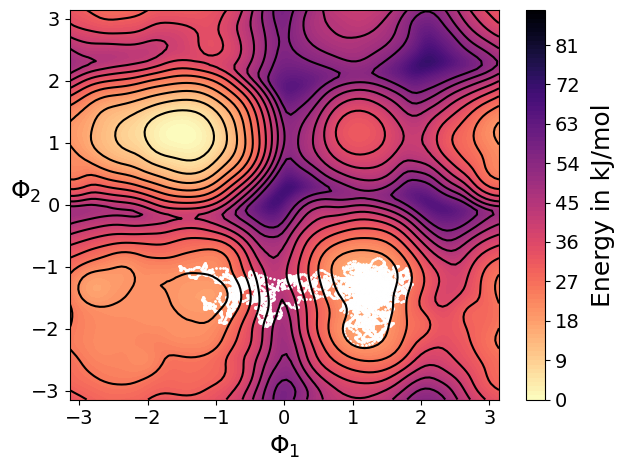

<Figure size 640x480 with 0 Axes>

In [156]:
data=plumed.read_as_pandas("fes-rew_phi1phi2.dat" )


phi_values = data['phi1']
psi_values = data['phi2']
file_free_values = data['file.free']

phi_grid, psi_grid = np.meshgrid(np.linspace(phi_values.min(), phi_values.max(), 100),
                                 np.linspace(psi_values.min(), psi_values.max(), 100))

file_free_grid = griddata((phi_values, psi_values), file_free_values, (phi_grid, psi_grid), method='cubic')

levels=np.arange(0,90,1)
s = plt.contourf(phi_grid, psi_grid, file_free_grid,levels, cmap='magma_r')

levels=np.arange(0,60,5)
plt.contour(phi_grid, psi_grid,file_free_grid,levels,colors='black')

for i in range(1,6):
    colvar_forward=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetBA%s" %i)
    
    print(len(colvar_forward['phi1']))
    phi_forward=colvar_forward['phi1']
    psi_forward=colvar_forward['phi2']
    plt.scatter(phi_forward,psi_forward,c='white',s=1)

cbar = plt.colorbar(s, shrink=1)
cbar.set_label(r'Energy in kJ/mol', rotation=90, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0)
plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()